### Imports

In [29]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import time 
import visdom
from os.path import expanduser

In [32]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, plot_sample, generate_corr_data
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net
from lib.nets import FNN, UNet
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector

from lib.utils_generate_n import n_r, n_i

In [33]:
torch.cuda.is_available()

False

### Parameter, paths, etc

In [34]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_create_initial_data = False
toy_data = True #if run on GPU machine, set to false
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

device = 'cpu'

# data
path_initial_data, path_corrector_data = get_data_paths(toy_data, device, home)

# plots
path_plots = 'plots/'
# ---------------------------------


# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
if toy_data:
    size_dataset = 8 #if run on GPU machine, set to 5000 (toydata 8)
else:
    size_dataset = 5000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

### Get data

In [5]:
initial_dataset = InitialDataset(csv_file = path_initial_data + 'k_values.csv', 
                               root_dir = path_initial_data,
                               transform = None)

In [6]:
initial_dataset[0]

{'k_n_r': array([10.,  1.,  1., ...,  1.,  1.,  1.]),
 'n_i': array([0., 0., 0., ..., 0., 0., 0.])}

[1. 1. 1. ... 1. 1. 1.]


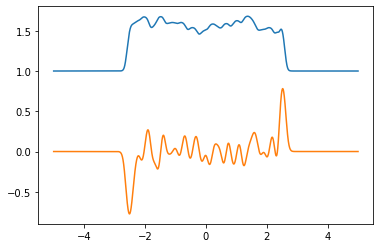

In [7]:
#show that it worked
idx = 6

print(initial_dataset[idx]['k_n_r'])

plt.plot(grid,initial_dataset[idx]['k_n_r'][1:])
plt.plot(grid,initial_dataset[idx]['n_i'])    

### Algorithmus

In [45]:
def nextni(dx, k, ni0, ni1, nr0, nr1, nr2):
    ni2 = ni0 + nr1/ni1*(nr2-nr0) - 4*k*nr1*dx*np.sqrt(nr1**2 - ni1**2)
    return ni2

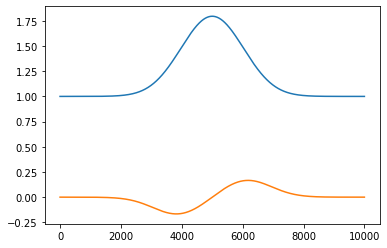

In [46]:
W = 5*gauss_dist(0,1,grid) + 1
dW = diff_same_length(W, stepsize)
k = 1
nr = n_r(W, dW, grid, k)
ni = n_i(dW, nr, grid, k)
plt.plot(nr)
plt.plot(ni)

In [50]:
nr0 = nr[0]
nr1 = nr[1]
nr2 = nr[2]
print(nr[:3])

ni0 = ni[0]
ni1 = ni[1]
print(ni[:3])

t1 = ni0
t2 = nr1/ni1*(nr2-nr0)
t3 = 4*k*nr1*stepsize*np.sqrt(nr1**2 - ni1**2)

print(t1,t2,t3)
print(t1 + t2 + t3)

print(nextni(stepsize, k, ni0, ni1, nr0, nr1, nr2))

[1.00000297 1.00000298 1.000003  ]
[-7.43173961e-06 -7.46748969e-06 -7.50340418e-06]
-7.431739610923545e-06 -0.003990520560850935 0.0040000238436675205
2.071543205662066e-06
-0.007997976144129379


In [42]:
stepsize

0.001000000000000334